## Code with constant and stochastic hurst exponent simulations

In [5]:
import numpy as np
import tensorflow as tf
from stochastic.processes.continuous import FractionalBrownianMotion
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import math
import pandas as pd
%matplotlib notebook

pi = math.pi

In [11]:
def gen_fbm_track(ntimes, hurst_exp, initial_position=[0,0,0]):
    """
    Function to produce single fbm track, with normalisation
    """

    fbm = FractionalBrownianMotion(hurst=hurst_exp,t=1,rng=None)
    x = fbm.sample(ntimes)
    y = fbm.sample(ntimes)
    z = fbm.sample(ntimes)
    
    #r = np.sqrt((np.amax(x)-np.amin(x))**2 + (np.amax(y)-np.amin(y))**2 + (np.amax(z)-np.amin(z))**2) 
    
    dx = (x[1:]-x[0:-1])/(np.amax(x)-np.amin(x))#r
    dy = (y[1:]-y[0:-1])/(np.amax(y)-np.amin(y))#r
    dz = (z[1:]-z[0:-1])/(np.amax(z)-np.amin(z))#r
    
    #dx = (x[1:]-x[0:-1])*hurst_exp
    #dy = (y[1:]-y[0:-1])*hurst_exp
    #dz = (z[1:]-z[0:-1])*hurst_exp
    
    x_norm = np.append(np.array([0]),np.cumsum(dx))
    y_norm = np.append(np.array([0]),np.cumsum(dy))
    z_norm = np.append(np.array([0]),np.cumsum(dz))

    x0, y0, z0 = initial_position
    #x, y, z = x+x0,y+y0,z+z0#
    x, y, z = x_norm+x0, y_norm+y0, z_norm+z0
        
    return x[:ntimes], y[:ntimes], z[:ntimes]

def track_until_reflection(xs, ys, zs, radius):
    """
    Function to restrict an initial track, based on cylindrical geometry
    returns shortened track
    """
    #input entire track
    indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
    if len(indices)>0:
        i = indices[0]
        xs = xs[:i]
        ys = ys[:i]
        zs = zs[:i]
    return xs, ys, zs
    """
    i = 0
    while True:
        if xs[i]**2 + ys[i]**2 > radius**2:
            index = i
            break 
        i+=1 
        
    xs = xs[:index]
    ys = ys[:index]
    zs = zs[:index]
    
    return xs,ys,zs
    """            

def split_track_at_collision(xs, ys, zs, radius):
    """
    Function to split track into pre and post collision segments
    """
    
    #input entire track
    indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
    i = indices[0]
    xs_before = xs[:i]
    ys_before = ys[:i]
    zs_before = zs[:i]
    xs_after = xs[i:]
    ys_after = ys[i:]
    zs_after = zs[i:]
    return (xs_before, ys_before, zs_before), (xs_after, ys_after, zs_after)

def exit_check(xs, ys, zs, radius):
    """
    Function to check if track has exceeded geometry
    """
    #input entire track
    indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
    if len(indices)>0:
        return True
    else:
        return False

def exit_step(xs, ys, zs, radius):
    """
    Function to return final step that takes haemocyte beyond restriction
    """
    #input entire track
    indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
    if len(indices)>0:
        i = indices[0]
        dx = xs[i+1]-xs[i]
        dy = ys[i+1]-ys[i]
        dz = zs[i+1]-zs[i]
    return dx, dy, dz

def exit_coords(xs, ys, zs, radius):
    """
    Function to return coordinates that exceed boundary
    """
    #input entire track
    indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
    if len(indices)>0:
        i = indices[0]
        
        xs = xs[i:i+2]
        ys = ys[i:i+2]
        zs = zs[i:i+2]
    return xs, ys, zs

def gradient(xs, ys):
    # 2 elements in xs, 2 elements in ys
    return (ys[1]-ys[0])/(xs[1]-xs[0])

def get_roots(xs, ys, r):
    # 2 elements in xs, 2 elements in ys
    x1,x2 = xs
    y1,y2 = ys
    
    m = gradient(xs, ys)
    a = m**2+1
    b = 2*m*(y1-m*x1)
    c = (m**2)*(x1**2) - 2*m*y1*x1 + y1**2 - r**2
    
    x_roots = np.roots([a,b,c])
    y_roots = m*(x_roots-x1)+y1
    
    return x_roots, y_roots

def get_intersection_point(xs, ys, r):
    # 2 elements in xs, 2 elements in ys
    x_roots, y_roots = get_roots(xs, ys, r)
    i = np.argmin((xs[1]-x_roots)**2+(ys[1]-y_roots)**2)
    
    return x_roots[i], y_roots[i]

def get_mod(v):
    
    return np.sqrt(np.dot(v,v))

def get_exit_angle(xs,ys,r):
    # 2 elements in xs, 2 elements in ys
    r_vector = np.array([get_intersection_point(xs,ys,r)])
    exit_vector = np.array([xs[1]-xs[0],ys[1]-ys[0]])
    
    rmod = get_mod(r_vector)
    exit_mod = get_mod(exit_vector)
    
    cos_theta = np.dot(r_vector,exit_vector)/(rmod*exit_mod)
    
    return np.arccos(cos_theta)

def acw_rotation_angle(xs,ys,r):
    # 2 elements in xs, 2 elements in ys
    r_vector = np.array([get_intersection_point(xs,ys,r)])
    exit_vector = np.array([xs[1]-xs[0],ys[1]-ys[0]])
    
    theta = get_exit_angle(xs,ys,r)
    rot_angle = np.pi-2*theta
    if np.cross(r_vector, exit_vector) > 0:
        return rot_angle
    else:
        return -rot_angle

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def fbm_track_with_reflection(hurst_exp, radius, ntimes, initial_pos=(0,0,0)):
    
    #generate entire track
    data_x, data_y, data_z = gen_fbm_track(ntimes, hurst_exp, initial_pos)
    
    #check if track exits cylinder
    keep_going = exit_check(data_x, data_y, data_z, radius)
    while keep_going:
        
        xs_exit, ys_exit, zs_exit = exit_coords(data_x, data_y, data_z)
        
        (xs_before, ys_before, zs_before), (xs_after, ys_after, zs_after) = split_track_at_collision(data_x, data_y, data_z,
                                                                                                     radius)
    
def gen_fbm_track_collisions(radius, ntimes,hurst_exp=None,initial_pos=(0,0,0)):
    """
    Function to generate full track, up to length ntimes, from a given initial position and 
    in a cylinder of specified radius. Concatenates tracks following collision to make 
    total fbm track
    """
    
    if hurst_exp == None:
        hurst_exp = np.random.uniform(0.001,0.999)
    
    data_x, data_y, data_z = gen_fbm_track(ntimes, hurst_exp, initial_pos)
    data_x, data_y, data_z = track_until_reflection(data_x, data_y, data_z, radius)
    
    initial_pos_array = initial_pos
    
    while len(data_x) < ntimes:
        
        #subtrack_length = ntimes - len(data_x)
        new_initial_pos = (data_x[-1], data_y[-1], data_z[-1])
        initial_pos_array = np.vstack((initial_pos_array, new_initial_pos))

        x, y, z = gen_fbm_track(ntimes, hurst_exp, initial_position=new_initial_pos)
        
        new_x = np.append(data_x, x)
        new_y = np.append(data_y, y)
        new_z = np.append(data_z, z)

        temp_x,temp_y,temp_z = track_until_reflection(new_x, new_y, new_z, radius) 

        if temp_x[-1]!=data_x[-1]:
            data_x, data_y, data_z = temp_x,temp_y,temp_z

    data_x, data_y, data_z = data_x[:ntimes], data_y[:ntimes], data_z[:ntimes]

    return data_x, data_y, data_z, initial_pos_array, hurst_exp
    

In [12]:
def plot_random_walk_single(axis, data_x, data_y, data_z, init_pos=[0,0,0],c_line='k',cmap_line=None):
    """
    Function to plot one random walk, has color arguments for different h values in stoch model
    """
    
    if cmap_line == None:
        axis.plot(data_x, data_y, data_z,color=c_line)
    else:
        axis.plot(data_x, data_y, data_z,color=c_line,cmap=cmap_line)
        
    axis.scatter(data_x[0], data_y[0], data_z[0], color='green')
    axis.scatter(data_x[-1], data_y[-1], data_z[-1], color='red')

In [13]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    """
    Function to generate data required for plotting the cylinder
    """
    z = np.linspace(-height_z/2, height_z/2, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

def plot_cylinder_along_z(axis, center_x, center_y, radius, height_z):
    """
    Function to plot cylinder in 3d plot
    """
    Xc,Yc,Zc = data_for_cylinder_along_z(center_x, center_y, radius, height_z)
    axis.plot_surface(Xc, Yc, Zc, alpha=0.1)
    axis.set_xlabel('x')
    axis.set_ylabel('y')
    axis.set_zlabel('z')
    axis.set_xlim(-1.5*radius, 1.5*radius)
    axis.set_ylim(-1.5*radius, 1.5*radius)

In [14]:
def plot_random_walks(axis, data_x, data_y, data_z):
    for i in range(len(data_x)):  # plotting each track
        axis.plot(data_x[i,:],data_y[i,:],data_z[i,:])
        
def get_rand_initial_pos(radius, z_lim=None):
    """
    Function to generate randomised initial position, within cylinder
    """
    
    if z_lim==None:
        z_lim = [-radius, radius]
        
    x0, y0 = np.random.uniform(-radius, radius, 2)
    z0 = np.random.uniform(-z_lim[0], z_lim[1], 1)
    
    while x0**2+y0**2 > radius**2:
        x0, y0 = np.random.uniform(-radius, radius, 2)
        z0 = np.random.uniform(-z_lim[0], z_lim[1], 1)
    
    return x0, y0, z0

def get_rand_initial_pos_2(radius,z_lim=None):
    """
    Function to generate randomised initial position, within cylinder
    """    
    r = radius*np.sqrt(np.random.random())
    theta = np.random.random()*2*pi
    
    x0 = r*np.cos(theta)
    y0 = r*np.sin(theta)
    
    if z_lim==None:
        z_lim = radius
    z0 = np.random.uniform(-z_lim, z_lim, 1)[0]
    
    return (x0,y0,z0)

<IPython.core.display.Javascript object>


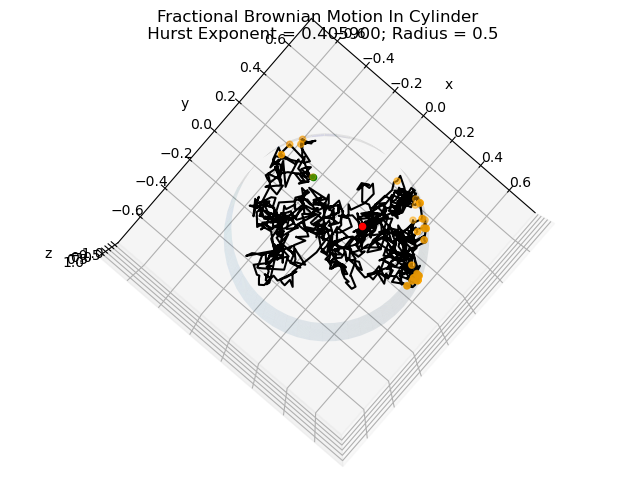

In [15]:
def plot_in_cylinder(r,nsteps,h = None,initial_pos=(0,0,0)):
    """
    Function to plot fbm random walk in cylindrical geometry
    """
    
    data_x, data_y, data_z, initial_pos_array,h_val = gen_fbm_track_collisions(r, nsteps,hurst_exp = h,initial_pos=initial_pos)

    fig = plt.figure()
    ax = Axes3D(fig)
    
    plot_random_walk_single(ax, data_x, data_y, data_z)
    plot_cylinder_along_z(ax,0, 0, r, 2*np.max(np.abs(data_z)))
    try:
        ax.scatter(xs=initial_pos_array[:,0], ys=initial_pos_array[:,1], zs=initial_pos_array[:,2], color='orange')
    except :IndexError
    
    plt.suptitle("Fractional Brownian Motion In Cylinder \n Hurst Exponent = {:f}; Radius = {}".format(h_val,r))

rand_pos_0 = get_rand_initial_pos_2(0.5)
plot_in_cylinder(0.5,1000,initial_pos=rand_pos_0)

In [44]:
def gen_mc_fbm_cylinder_data(radius, track_length, mc_samples,model_type,h_noise_amp=0.1):
    """
    Function to generate panda dataframe from many monte carlo repeats of 
    fbm in pipe simulation. Track length is always equal, of size track_length, 
    with number of mc repeats = mc_samples. Model type specifies whether to use
    the same hurst after collisions, a stochastic one or a constant one with 
    classical reflection.
    Model types: 'const_h', 'stoch_h', 'const_h_refl'
    h_noise_amp: amplitude of noise term for stoch_h model
    """
    
    xyz_step_track_time_arr = np.empty((mc_samples*track_length, 7))

    for i in np.arange(mc_samples):
        
        track_id_arr = np.full((track_length,1),i)
        timestep_arr = np.arange(track_length)
        timestep_arr = np.reshape(timestep_arr,(track_length,1))
        timeabs_arr = 17.6*timestep_arr
        
        initial_position = get_rand_initial_pos_2(radius)
        
        if model_type=="const_h":
            x,y,z,_,h_val = gen_fbm_track_collisions(radius, track_length,hurst_exp = None,
                                                     initial_pos=initial_position)
            h_arr = np.full((track_length,1),h_val)
        elif model_type=="stoch_h":
            x,y,z,_,h_arr =gen_fbm_track_collisions_stoch_h(radius, track_length, h_noise_amp, lower_h_lim = 0.001,
                                                            upper_h_lim = 0.999, initial_pos=initial_position)
            h_arr = np.reshape(h_arr,(track_length,1))
            
        x = np.reshape(x,(track_length,1))
        y = np.reshape(y,(track_length,1))
        z = np.reshape(z,(track_length,1))
        
        xyz_step_track_time_arr[i*track_length:(i+1)*track_length,:] = np.hstack((x,y,z,timestep_arr,
                                                                                  track_id_arr,timeabs_arr,h_arr))
    
    header_arr = ["Position X","Position Y","Position Z","Time","TrackID","Absolute T","Simulated Hurst"]
 
    xyz_step_track_time_df = pd.DataFrame(xyz_step_track_time_arr, columns = header_arr)
    
    return xyz_step_track_time_df

def save_to_csv(track_df,radius,track_length,mc_samples,model_type,h_noise_amp=None,folder_path=None):
    """
    Function to save panda dataframe from mc simulation
    Model types: 'const_h', 'stoch_h', 'const_h_refl'
    h_noise_amp: amplitude of noise term for stoch_h model
    """
    if model_type == "const_h":
        filename = "{}_r{:.1f}_l{}_mc{}_cylinder_data.csv".format(model_type,radius,
                                                              track_length,mc_samples)
    elif model_type == "stoch_h":
        filename = "{}_hna{:.1f}_r{:.1f}_l{}_mc{}_cylinder_data.csv".format(model_type,h_noise_amp,radius,
                                                              track_length,mc_samples)
        
    if folder_path!=None:
        filename = folder_path + filename
        
    track_df.to_csv(filename,index=False)
    
def gen_mc_fbm_cylinder_csv(radius,track_length,mc_samples,model_type,h_noise_amplitude=0.1,folder_path=None):
    """
    Function to generate and save mc data, fbm in pipe
    Model types: 'const_h', 'stoch_h', 'const_h_refl'
    h_noise_amp: amplitude of noise term for stoch_h model
    
    """
    xyz_step_track_time_df = gen_mc_fbm_cylinder_data(radius,track_length,mc_samples,
                                                      model_type,h_noise_amp=h_noise_amplitude)
    
    save_to_csv(xyz_step_track_time_df,radius,track_length,mc_samples,
                model_type,h_noise_amp=h_noise_amplitude,folder_path=folder_path)
    
    return xyz_step_track_time_df
    

In [45]:
df = gen_mc_fbm_cylinder_csv(0.5,100,100,"const_h",folder_path="sim_haemocyte_pipe_data/const_h/")

0.19690207923973072
0.9749049526584438
0.6347309785441811
0.6069868179317863
0.035098766510875734
0.8504984904312308
0.6429423009824865
0.5901070882286858
0.4726558107747201
0.17543940480450054
0.44067720684400136
0.13607523952139342
0.4956344848485732
0.604267896016526
0.28665948029800875
0.6050501211107933
0.45942472384432764
0.1388977811766504
0.2982302520978605
0.09790884142868254
0.7657746764313792
0.0037925709885218407
0.22992979323315135
0.17349192627340115
0.2064899918691889
0.7724434745597777
0.010385791991402472
0.40455363468757
0.660765176669996
0.6659554239220571
0.7025735866299275
0.6912610657095297
0.35494282893741463
0.592773645250779
0.9067701438974094
0.6967053142503528
0.15657234718908966
0.8976192259519274
0.6127524344229272
0.7407446117858699
0.9015470845526625
0.3588518582176132
0.6428000278029976
0.6137304874959261
0.7237945190221217
0.2799851979630874
0.8383479045998279
0.33637053362244473
0.7909790818996443
0.1258032173994223
0.5921593116743137
0.450339890740903

In [27]:
df['Position X']

0       0.220261
1       0.216918
2       0.232666
3       0.214313
4       0.188878
          ...   
9995    0.345170
9996    0.351843
9997    0.273912
9998    0.147771
9999   -0.075799
Name: Position X, Length: 10000, dtype: float64

## Stochastic Hurst Exponent

In [39]:
def crawling_h_uniform_dist(length, amplitude, abs_lower_lim, abs_upper_lim):
    """
    Function to generate array of h exponent values, using stochastic method
    hurst value updates iteratively based on previously value, with new sample
    generated from a uniform distribution centred on the previously value
    - when the previous value is near the limits, the uniform distrivution shifts 
    away from the limit
    amplitude: noise amplitude ( how large is the uniform distribution)
    abs____lim: upper and lower limits to be bound by, 0 and 1 for hurst
    """
    h_arr = np.empty(length)
    h0 = np.random.uniform(abs_lower_lim,abs_upper_lim)
    h_arr[0] = h0
    
    for i in np.arange(length-1):
        
        lower_lim,upper_lim = gen_lims(h_arr[i],amplitude,abs_lower_lim,abs_upper_lim)

        h_arr[i+1] = np.random.uniform(lower_lim,upper_lim)
    
    return h_arr

def gen_lims(centre,amplitude,absolute_lower_lim,absolute_upper_lim):
    """
    Function to generate limits of uniform distribution to sample from for next 
    hurst value, in 'crawling_h_uniform_dist'. Shifts range of uniform distribution 4
    in opposite direction, and equal to amount the distribution oversteps by.
    centre: previous hurst value
    """
    #temporary values of new limits, symetrically centred on previous value
    temp_ll = centre - amplitude/2
    temp_ul = centre + amplitude/2
    
    if temp_ll < absolute_lower_lim:
        #if temp. lower lim is less than abs. lower lim, reset
        # and increase upper lim by lower limit overstep
        ll = absolute_lower_lim
        ul = temp_ul + abs(temp_ll-absolute_lower_lim)
    
    elif temp_ul > absolute_upper_lim:
        #if temp. upper lim is more than abs. upper lim, reset
        # and decrease lower lim by upper limit overstep
        ll = temp_ll - abs(temp_ul-absolute_upper_lim)
        ul = absolute_upper_lim
        
    else:
        ll = temp_ll
        ul = temp_ul
        
    return ll,ul
    
stoch_h = crawling_h_uniform_dist(100,0.05,0.001,0.999)  

<IPython.core.display.Javascript object>


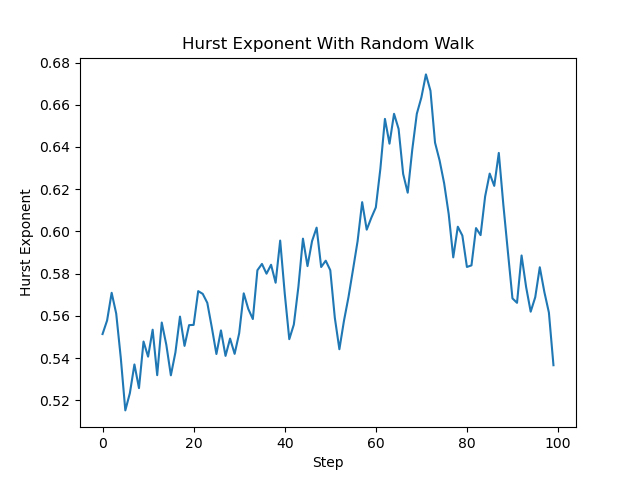

In [40]:
fig,ax = plt.subplots()
plt.plot(np.arange(len(stoch_h)),stoch_h)
plt.title('Hurst Exponent With Random Walk')
plt.xlabel('Step')
plt.ylabel('Hurst Exponent')
plt.show()

In [41]:
def gen_fbm_track_collisions_stoch_h(radius, ntimes, h_noise_amp, lower_h_lim = 0.001,
                                     upper_h_lim = 0.999, initial_pos=(0,0,0)):
    """
    Function to simulate restricted fbm track in pipe, using stochastic hurst 
    exponents following collisions. Track length is always equal, of size ntimes.
    lower_h_lim and upper_h_lim specify absolute values of hurst to be bounded by
    h_noise_amp: amplitude of noise term for stoch_h model
    """
    #stochastic hurst exponents generated at start
    input_hurst_arr = crawling_h_uniform_dist(ntimes, h_noise_amp, lower_h_lim, upper_h_lim)
    
    #first tracks are 
    data_x, data_y, data_z = gen_fbm_track(ntimes, input_hurst_arr[0], initial_pos)
    data_x, data_y, data_z = track_until_reflection(data_x, data_y, data_z, radius)
    initial_pos_array = initial_pos
    
    output_hurst_arr = np.full((1,len(data_x)),input_hurst_arr[0])

    i = 0
    while len(data_x) < ntimes:
        
        new_initial_pos = (data_x[-1], data_y[-1], data_z[-1])
        initial_pos_array = np.vstack((initial_pos_array, new_initial_pos))
        
        x, y, z = gen_fbm_track(ntimes, input_hurst_arr[i+1], initial_position=new_initial_pos)
        
        new_x = np.append(data_x, x)
        new_y = np.append(data_y, y)
        new_z = np.append(data_z, z)
        
        temp_x,temp_y,temp_z = track_until_reflection(new_x, new_y, new_z, radius)

        if temp_x[-1]!=data_x[-1]:
                               
            new_hs = np.full((1,len(temp_x)-len(data_x)),input_hurst_arr[i])
            output_hurst_arr = np.append(output_hurst_arr, new_hs)
            data_x, data_y, data_z = temp_x,temp_y,temp_z
        
            i += 1
        
    data_x, data_y, data_z = data_x[:ntimes], data_y[:ntimes], data_z[:ntimes]
    output_hurst_arr = output_hurst_arr[:ntimes]
    return data_x, data_y, data_z, initial_pos_array, output_hurst_arr

def plot_in_cylinder(r,nsteps,model_type,h = None,h_noise_amp = 0.1,initial_pos=None):
    """
    Function to plot fbm track in cylinder, with either model type
    """    
    fig = plt.figure()
    ax = Axes3D(fig)
    
    if initial_pos==None:
        initial_pos = get_rand_initial_pos_2(r)
    
    if model_type == "const_h":
        
        data_x, data_y, data_z, initial_pos_array,h_val = gen_fbm_track_collisions(r, nsteps,hurst_exp = h,
                                                                                   initial_pos=initial_pos)
        plot_random_walk_single(ax, data_x, data_y, data_z)
        plt.suptitle("Fractional Brownian Motion In Cylinder \n Hurst Exponent = {:f}; Radius = {}".format(h_val,r))
        output = (data_x, data_y, data_z, initial_pos_array,h_val)
    elif model_type == "stoch_h":
        
        data_x, data_y, data_z,initial_pos_array,h_arr = gen_fbm_track_collisions_stoch_h(r, nsteps, h_noise_amp,
                                                                                          lower_h_lim=0.001, upper_h_lim=0.999,
                                                                                          initial_pos=initial_pos)
        plot_random_walk_single(ax, data_x, data_y, data_z)#,c_line=h_arr,cmap_line='inferno')
        plt.suptitle("Fractional Brownian Motion In Cylinder \n Stochastic Hurst Exponent; Radius = {}".format(r))
        #fig.colorbar(label='Hurst Exponent')
        output = (data_x, data_y, data_z,initial_pos_array,h_arr)
         
    
    plot_cylinder_along_z(ax,0, 0, r, 2*np.max(np.abs(data_z)))
    try:
        ax.scatter(xs=initial_pos_array[:,0], ys=initial_pos_array[:,1], zs=initial_pos_array[:,2], color='orange')
    except :IndexError
        
    return output

    

<IPython.core.display.Javascript object>


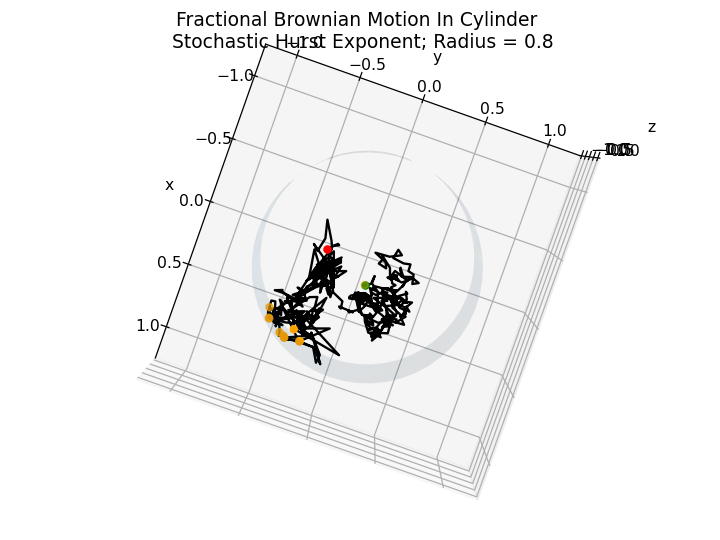

<IPython.core.display.Javascript object>


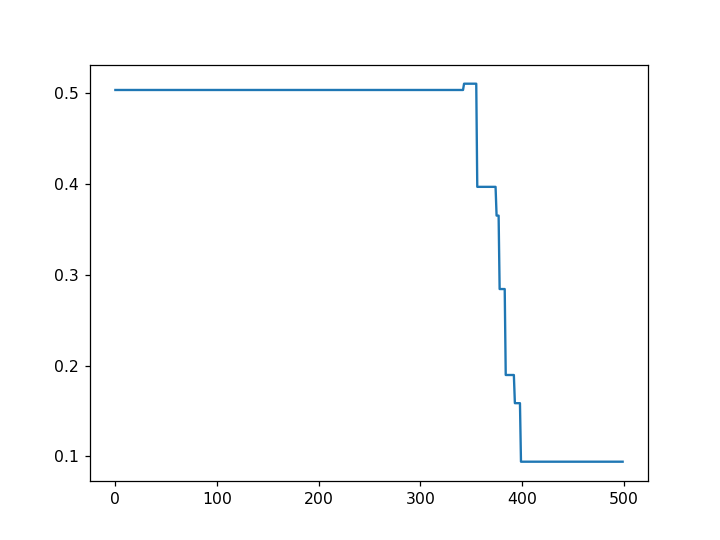

In [359]:
x,y,z,init_pos_arr,h_arr = plot_in_cylinder(0.8,500,"stoch_h",h_noise_amp = 0.3)

fig = plt.figure()
plt.plot(h_arr)
plt.show()



In [309]:
df_stoch = gen_mc_fbm_cylinder_csv(0.5,100,1000,"stoch_h",h_noise_amplitude=0.1,folder_path="sim_haemocyte_pipe_data/stoch_h/")

In [310]:
df_stoch

,Position X,Position Y,Position Z,Time,TrackID,Absolute T,Simulated Hurst
0,-0.171441,0.450909,-0.039769,0.0,0.0,0.0,0.437843
1,-0.171441,0.450909,-0.039769,1.0,0.0,17.6,0.402157
2,-0.171541,0.421212,0.003252,2.0,0.0,35.2,0.402157
3,-0.301158,0.354401,0.140153,3.0,0.0,52.8,0.402157
4,-0.365216,0.239521,0.002684,4.0,0.0,70.4,0.402157
...,...,...,...,...,...,...,...
99995,0.275820,-0.335768,-0.453596,95.0,999.0,1672.0,0.372265
99996,0.323004,-0.286816,-0.357439,96.0,999.0,1689.6,0.372265
99997,0.192554,-0.364390,-0.452314,97.0,999.0,1707.2,0.372265
99998,0.192554,-0.364390,-0.452314,98.0,999.0,1724.8,0.376258


In [46]:
def gen_data_different_radii(r_lower,r_upper,r_step,track_length,mc_steps,model_type,
                             h_noise_amplitude=0.1,folder_path="sim_haemocyte_pipe_data/stoch_h/"):
    """
    Function to collect mc data for fbm restricted tracks for different radii of pipe
    """
    radii = np.arange(r_lower,r_upper,r_step)
    
    for i, r in enumerate(radii):
        
        gen_mc_fbm_cylinder_csv(r,track_length,mc_steps,model_type,
                                h_noise_amplitude=h_noise_amplitude,
                                folder_path=folder_path)


In [47]:
gen_data_different_radii(0.1,1.6,0.1,200,1000,"const_h", h_noise_amplitude=0.1,folder_path="sim_haemocyte_pipe_data/const_h/")

0.661825069832415
0.07470204630977285
0.20384110608499909
0.49592219667873827
0.08562078395508255
0.857014651673076
0.6936466527232673
0.3629642962406352
0.6669566260927257
0.5339015155205914
0.742929865644306
0.8881583236127519
0.8362303815084934
0.7872977409920169
0.6398191642594158
0.09452550824336216
0.695191178876087
0.7002331475915589
0.8188810675396401
0.020870444635696837
0.5935963325074016
0.4222649317729055
0.4333855993022521
0.19965661213498226
0.6118083551794065
0.3892348702889253
0.9322797552648167
0.39645693877831883
0.24023578100374937
0.05668375513182906
0.25048130359908727
0.46574906799106486
0.7462225170162715
0.8826035294565909
0.09172213796264586
0.8324881538607848
0.525088018454167
0.3836456098889576
0.529049693931607
0.1458635579296989
0.555711061841199
0.004883986884911416
0.37093806768703397
0.6818477133868835
0.6068931930437755
0.4379684397341561
0.39246177873089594
0.8345962069044821
0.6554880070887635
0.03210689856834449
0.28928701433593634
0.9727417403973657

0.14888183118450674
0.527856490793909
0.1899008349030999
0.810196894815792
0.6827914730035837
0.17025856345729307
0.3993465787432966
0.4077793809095514
0.6495924315898516
0.9175503645329091
0.6813497448815168
0.16183825627721363
0.5311209850658035
0.0973129217860513
0.9208073349833532
0.9152291130122476
0.7121278818941125
0.5948301009646174
0.874228146639459
0.4595386941527061
0.9627564898040369
0.7506013286196299
0.22872974219954972
0.0988565270544537
0.7798173983395327
0.13826332557973908
0.9519657760627859
0.16425517266418402
0.6568609261349379
0.2905701990086783
0.5872527250463978
0.765719384309059
0.17215120276485307
0.8325452254924398
0.9881018273305794
0.3696027689956737
0.5124871211022621
0.361017781124272
0.010574307054002696
0.869316327095615
0.45645760422750264
0.5006480922384204
0.5431033731012731
0.7153517836449774
0.920548532931879
0.6577047927910776
0.43341939091291526
0.5529005683764082
0.02105215333108256
0.08490026161494163
0.7617056769322983
0.7356204610256077
0.9595

0.4436569777961175
0.6633691631056656
0.4866463400168164
0.9000974126195511
0.08343314798742452
0.4174423690269024
0.5842682232871218
0.6577436791906133
0.28716730232534504
0.49933008150724095
0.8825763672533725
0.9930224255710233
0.13570479992542092
0.6680008193217192
0.8168261966061441
0.42959949888395005
0.32848531796251046
0.5682483005442092
0.6661918078962198
0.8715797580748421
0.39655184284914075
0.387689138063392
0.04982399129050948
0.34519523614865977
0.7315307457217529
0.5171529620420137
0.39354222510729714
0.031112655337447316
0.09114621103642007
0.6141793111108088
0.3787242841166679
0.9652629710682122
0.7069535055254038
0.4378413748366389
0.17865541214808142
0.32392199413729605
0.3304123372769298
0.5957686823481851
0.7517874699998669
0.435996806609841
0.6636327717884623
0.7961538722091991
0.48882572288476384
0.031108477743945456
0.7223189623092963
0.7634406783649511
0.7607714251117589
0.7607906987152963
0.1370286305016701
0.5738545057656866
0.26609076059866943
0.120811875348

0.37120420185231956
0.09570538722348258
0.27372231892833626
0.4925923891761044
0.32854838503901246
0.7477745726254608
0.3108570405932028
0.2866896508115166
0.15950029374725208
0.8076267161985587
0.24764960544778306
0.25598793098338396
0.7440343462746115
0.41926742119472643
0.25994854883790364
0.8658551482157679
0.4358973240127215
0.9532634327847747
0.7060897854135841
0.8822921837865615
0.7427431704573823
0.38205324399037266
0.1444390988104995
0.9652154223647467
0.8930428013392939
0.6021006952082604
0.19062093386164838
0.12902226560724467
0.03521643897984214
0.781754521410834
0.7168111342558658
0.04788376923829757
0.946090980799359
0.15749055602067752
0.2978835858920888
0.19842316996666867
0.7067089372593586
0.9755362524725295
0.011028981581438998
0.11512068285707552
0.34208820991379785
0.5717203487246436
0.05734822930047113
0.502363860517633
0.2388511397683235
0.47389547834563944
0.5405548983164075
0.8717579703176092
0.34926120078345435
0.7597540097016053
0.8453330430714187
0.609034156

0.3400952814665081
0.8807710747722329
0.925839606919141
0.8068148004100024
0.7188550331031306
0.7426282109196146
0.18064771730571974
0.6963072981843337
0.550867441241928
0.9385959837897752
0.5018187520169113
0.43779368955215686
0.2300611755221008
0.5079495817187363
0.17371624120516066
0.19385988313795832
0.539574610587073
0.8852193918712917
0.49023280508391126
0.5603951713656683
0.048725429303145794
0.7293921840985608
0.5636373272492818
0.13704814955994038
0.15135378582691997
0.8796039394458471
0.20817335154750877
0.2971264063540834
0.785809853609397
0.4363947575648665
0.9732301736035188
0.808968394748286
0.654961142416636
0.37070681453057763
0.22492625725828977
0.7074051835376267
0.48139917084288386
0.7501899722428376
0.17159645565049797
0.6992119796280071
0.9761793177733544
0.03273917433744797
0.79835495339807
0.9243914381268896
0.03607280267721671
0.4499724754261583
0.762570036579151
0.2556851630109477
0.1497101248340992
0.9392748469899397
0.45790562680045643
0.01836065739015378
0.5

0.003909290695890825
0.9891380966679338
0.5752932555136712
0.5222522296151022
0.5186972800265017
0.09465034962455568
0.9898533833534028
0.6620122079165116
0.3619393303281228
0.40608009348572144
0.31906739736078366
0.7593976196110349
0.6632312439231479
0.3082889300158308
0.38702354023468377
0.5053381404164302
0.23055267811685123
0.9607069075871397
0.3293595621704282
0.9843942786027042
0.09203464827142774
0.6841857140366017
0.8232358847832986
0.7508609382804433
0.5790907900015612
0.4550904420101245
0.05254955956993053
0.04573946177490613
0.23048822916776812
0.21475219941569207
0.9358499979625496
0.9117184691186012
0.5430997872209922
0.3350733334829651
0.9699916551354552
0.8965186760478366
0.7703240917724218
0.1195351990338492
0.03639351951158012
0.08046811707751976
0.3291253060080418
0.186615979686242
0.4717421977920286
0.6333812804973008
0.6354476892642403
0.27769209204501244
0.9857503707320965
0.560764864447642
0.8013734992434095
0.044569678525601585
0.811292798392034
0.953746985612126

0.012785546668239008
0.30541415996163485
0.5468953433976831
0.855937355661031
0.5859607135151691
0.4030566858608938
0.5612086154683718
0.33307828214243856
0.6138778628741681
0.7041926416895287
0.9007560376760606
0.3405865768366738
0.6140566290723458
0.4575612163007312
0.6056932303226635
0.414749338157043
0.3162865450087726
0.6191108807250916
0.10156593487091313
0.9762258962650933
0.8552387235265062
0.8253516386026677
0.722853903642347
0.8432077899720942
0.5465458666638163
0.0023199657084447796
0.22188784367100933
0.48611120596310614
0.6059989417287008
0.6621746059953276
0.6279742643142363
0.9125816311346228
0.9611667653903933
0.27904676523910804
0.033522376142525415
0.7550694605404275
0.8043209629314056
0.7793408417708952
0.7193044198680584
0.673251358659464
0.17764131572363417
0.0456182144715261
0.06375977058398821
0.17711729569989432
0.6101774870414887
0.5165894490564259
0.7275050954760145
0.34346647504017536
0.17505668086533813
0.33828177202375304
0.8413627641387704
0.31010573810453

0.36327422168610746
0.6678411246646162
0.4582162931029843
0.9162149251067139
0.9809441922739541
0.21093477962236745
0.25367570916128773
0.8499581433976352
0.028640563676474513
0.7111551180020325
0.04359068353385637
0.41766303571403507
0.825728677617552
0.31145257670373816
0.9671151034830774
0.7453698663765896
0.12382317501266887
0.6164369794091691
0.9003888577349852
0.7970833872388586
0.8951679344330787
0.299077441569115
0.9036107792768077
0.6406824225081507
0.9596139643048857
0.4118570237858801
0.6387778629081738
0.1698136710493516
0.706803742533341
0.2688913591146903
0.8728591921893094
0.2539330071457686
0.9172161224667114
0.8314730361230911
0.5907180431196838
0.39724177055960475
0.05139519325924904
0.15131849964853236
0.4540255815956859
0.9742029670770876
0.0022136345514767244
0.07383792491887108
0.917020836682066
0.61619200778417
0.9621990546780164
0.08852693693399777
0.6746184544187116
0.25395129877922334
0.01979424198861223
0.713338684163177
0.42138578341666305
0.9470165556782818

0.02797456826680135
0.6070038403768975
0.9676927227712101
0.3760818992386922
0.7848977869586774
0.5746360498799645
0.29073950874360643
0.5517127382933597
0.11458042928163888
0.9617162472636118
0.6879179950275981
0.11526085399919814
0.1329382146929197
0.4752258381010956
0.2731501576514657
0.49096282613955233
0.11514375434211825
0.3776751322637285
0.5701358181903876
0.4440505446194818
0.8324731533045149
0.2202932111071585
0.6955463269902159
0.4927050244498618
0.4311811398610357
0.0984908245188215
0.5258590082182678
0.44873307882024643
0.5470224659221505
0.802909273900641
0.5628395984779699
0.8661303067695153
0.38221605626106364
0.8168958328777992
0.2078180208949866
0.8773009818875719
0.19837622139120623
0.3176357715852587
0.41788768770721313
0.7332738193849972
0.46328148734960495
0.5485140681655434
0.23429788869741458
0.7088410801315677
0.49034620887589386
0.5605807501143492
0.23588047488163422
0.4264132376654614
0.3730604977428279
0.4721599928816332
0.4926996257219139
0.548073364792861


0.8472908290258365
0.9936760365689803
0.9508560562207647
0.435747404281061
0.9743254488585811
0.8663759606717008
0.34860107581789984
0.8357577539272539
0.7445632841815151
0.631245664711086
0.4776428850102412
0.29446430818048686
0.6012586131103921
0.6905437188402788
0.8280297674679672
0.14802315718961168
0.025953537355348773
0.11372676158577713
0.9320966938966103
0.7222373355772904
0.9206568632234651
0.5011795150761057
0.5019101047193447
0.6579779415482607
0.07061250447556028
0.4084735273759087
0.669628772108856
0.15323791888416055
0.03451524180718803
0.72488417355715
0.28317245101686783
0.18307047849231708
0.3281673135627272
0.14839932528554814
0.12176010806121182
0.9054085032839164
0.589035373058287
0.19614839018063235
0.9386439995183677
0.6400085927543675
0.34974778629758835
0.6918689885136678
0.027874075888299363
0.3487548251716488
0.780693751605785
0.7036743889139926
0.8985629884682785
0.9956110543991961
0.7286901020624961
0.7041027678610055
0.9015429923710148
0.033520464633939866


0.11264522671146188
0.178577195148677
0.9528631682327744
0.9122161234369698
0.2890595008244342
0.9015365037319379
0.913738680847968
0.7009306827998569
0.02599292170418185
0.6407718785299559
0.23941207741024761
0.15367543482145612
0.8725938835961257
0.6422760977620388
0.6131677414402437
0.05526269711789728
0.09032913944174162
0.03576234543410444
0.6446702402045608
0.6458709464286532
0.7500522894757138
0.26532679345124466
0.4744328407232259
0.39947463291358154
0.2820080230595553
0.4893717828933703
0.4993412936043678
0.5860060223322177
0.0849014955781429
0.8686483805395592
0.1896022693259526
0.9248287106388733
0.6254405904353958
0.6593929493450554
0.5477629563769427
0.6903074809781293
0.34491013537696713
0.6091075579511287
0.7096073017129589
0.263570520509288
0.02725317374892184
0.09979953088810614
0.7046515816029829
0.9217142722172942
0.2576338400715742
0.5635045879401634
0.649918352538274
0.9158343756028593
0.9656499039377251
0.42496383594238435
0.8663133169710102
0.8010235347218492
0.2

0.7473543596545742
0.05307592664560943
0.20781534262500992
0.8409263041886506
0.4071811537914981
0.2748891842022169
0.7164108568209875
0.4587526353885218
0.3034762702210317
0.6604303066440549
0.5545826722064372
0.13156849403594015
0.262463891313453
0.1705219803623802
0.946276521600324
0.6242085087295889
0.6603814817497377
0.20216549879669224
0.45806621270090064
0.2600684739214735
0.34166422300115
0.6395737475148924
0.2737561205126048
0.3246917978247622
0.3338288079430859
0.3321931918098131
0.051610644902911916
0.4024384989038787
0.3550990578336574
0.6428708847588117
0.36502534276669313
0.4205213754567411
0.12364965134197127
0.8673918204354919
0.4485159912229089
0.8850774787023633
0.9772452922130864
0.6346305200870958
0.010222491289029991
0.3315837914287005
0.7705649459452173
0.447240200440679
0.10016568006064434
0.9574347451200744
0.17529696471097142
0.030359344702262644
0.1518360509794291
0.22763559076518422
0.18800289777504006
0.7229559214573191
0.026663928932603265
0.317494280363031

0.6550644890666941
0.5602841490759718
0.5950684280661667
0.9952295913829589
0.7650506144906125
0.018214688761639238
0.32480512160599956
0.9040333012933468
0.16698236951003317
0.7492218950718961
0.3202294258910109
0.13565043367956417
0.15182518024244712
0.26704613889729933
0.8681888249468485
0.09998988864648753
0.4088140496594372
0.11921153436232101
0.5299980435021016
0.18354656885065934
0.05017091372885306
0.21710647352284101
0.3907896008215943
0.6603648140562985
0.9845540222634436
0.009779909157493716
0.640208312442096
0.4805912465111096
0.39619469564048404
0.8180764598195164
0.4615005847145079
0.876461695966647
0.7404382499800047
0.8370461444224192
0.7571195495264955
0.07460875055722156
0.39105468037071606
0.3825530640895289
0.7177144208178791
0.10975060903968649
0.859911649620929
0.26272118690859975
0.21906879184570507
0.15198445341368885
0.3997555632532674
0.13377879471887463
0.18326477596236376
0.11705110706565387
0.8599407354692757
0.9664845455607864
0.49200580041918723
0.5848316

0.45063150517675604
0.9486606452987381
0.6624557683661402
0.6089769767197014
0.25953074423560835
0.027841473610484342
0.9440645880515149
0.11244343667398114
0.7690943684332026
0.5217109037938894
0.9151912421312982
0.05344163305382721
0.06800844442097209
0.08549750436171616
0.8769109978675023
0.03404220816303166
0.8345576619167299
0.8852270818306975
0.3426738425010296
0.2414070683441965
0.883962076832085
0.3326042536402173
0.3709343684605218
0.6723840607849677
0.6123664266395997
0.117390425714073
0.9050105921861822
0.5434496067694509
0.8601527291858552
0.1516499198760406
0.002250659331792268
0.7740450558388715
0.6621891715197133
0.5740845814871973
0.03682373767691862
0.9388116477309608
0.8125409911522118
0.6439131068152508
0.7337786293276741
0.6476055890455008
0.639512549116083
0.49789929953941287
0.35159369984595434
0.7022013062723255
0.04076327146856145
0.4964858826141863
0.47674367606654194
0.20006192182144777
0.9351149955483464
0.5458712794941862
0.23826607866126198
0.84551660820022

0.016896568381049696
0.7205141159036983
0.32150023905150393
0.08062208475234313
0.1361686273684772
0.985307046513109
0.357127307778069
0.9038891257880952
0.8282628825967964
0.448792245930506
0.34246349456809955
0.23004418265861848
0.4985394233674467
0.7295154801391249
0.1579405326301701
0.5054950525453905
0.7414765277831916
0.7285806997184574
0.9374399986083611
0.44551541728645355
0.1496982798753844
0.0967724549872003
0.7620661441634994
0.9004677205675921
0.9378805086133425
0.30372962059496494
0.24712372677981365
0.6650884240795951
0.14467244367307378
0.2483221190379937
0.8065745023553614
0.3535022724625228
0.4598713485470124
0.37999551069266696
0.5399552261856274
0.09016937103048983
0.3832221187939902
0.7129285944468098
0.6756031842100438
0.33119384091045795
0.4060369641063071
0.14867416577296136
0.8865100490387529
0.11772929634762207
0.8177346639578494
0.3141034481506726
0.022314956620813543
0.6374219376925976
0.008268303252341179
0.45059774824337645
0.9369011031200899
0.045306121257

0.6335251967843971
0.6183788698916471
0.5234339924751163
0.8397362090530796
0.6239481245177095
0.1738256224976254
0.705550567307702
0.6998184152006036
0.6166619432951609
0.946685432862089
0.9407231366864371
0.49829405810183997
0.0685163507008324
0.6695157518343838
0.010582839351776254
0.899494874712798
0.6122597560469792
0.9046281345202554
0.5545037339966616
0.03373058861083514
0.580149279515567
0.9805447863976046
0.6141215056548288
0.37571437127711427
0.9564195751130407
0.7418839360432637
0.3857607017951155
0.9359991900466472
0.322531589513175
0.8769118352083132
0.11154038125959646
0.25903707025908995
0.34074847434733346
0.4775186411785436
0.6182402353359421
0.9277912165125
0.37743777876138895
0.7384005399298994
0.9908370578889987
0.3783600515045391
0.2357739613642969
0.08366634658224834
0.8262529414641254
0.7161266532691059
0.4817489555385332
0.637518872043094
0.19621743950783868
0.44469557761765804
0.8728118475609338
0.2405086417846794
0.9367943281085971
0.7439293287406088
0.4109926

0.5055314282146037
0.7403843486225058
0.03421673123339537
0.795679891539962
0.3308220146499636
0.5863980489910697
0.7881547387066764
0.1683941079822331
0.6334172602832833
0.8788452236735692
0.9126834419821768
0.8875214221553007
0.896089200835574
0.4961831232106965
0.6191201145942191
0.34476135607127484
0.7204095318036264
0.6059020191939801
0.6890198023600194
0.06841287202560989
0.4827132297826035
0.754031742562448
0.39316428286109506
0.42321693150068507
0.4619500320063472
0.25538243912389397
0.6616758141696099
0.10339463741232247
0.7867160334269787
0.8448551750407485
0.9806352723461533
0.04771648588167233
0.539228004586156
0.9782997841045399
0.6425997687600586
0.9330153881101622
0.7766450620783633
0.8308710142924953
0.25572688843016445
0.7373600356319463
0.46835379344306965
0.10472050208094415
0.10701307706215979
0.28861138066806363
0.26031191141577864
0.22012580067160123
0.9854189369135625
0.8596835901023024
0.435454521541815
0.47153334621739035
0.20117934262397677
0.9881077141533929


0.4295583718342336
0.4418575234201725
0.737006157987568
0.6428309283254869
0.6441827998626415
0.5719032085679838
0.912129094658805
0.3806337574780088
0.7863880757525082
0.9328152857488756
0.9941388804903426
0.11853815014382917
0.5893266438799333
0.028147950212354295
0.678460192236729
0.7237206542338019
0.6208088486682218
0.18580650987470973
0.9943254186304069
0.36732355470962025
0.4535735086931314
0.25242585009940594
0.8420589508028173
0.23500142781089256
0.9825870862714176
0.39101608630631535
0.6436094251883602
0.048411733904005515
0.488868583807716
0.9847952244329056
0.5908824673945886
0.8319610272633419
0.45926476776907954
0.7907487416858423
0.1310281035955766
0.6891817898068888
0.8841833424431883
0.0553190389011547
0.379311274703387
0.672337651833155
0.33398018168028165
0.9201854865025568
0.6140430636280224
0.4842556733399296
0.14373764919895815
0.8300968133292015
0.3940843214934393
0.7020510364949905
0.649686543369314
0.03408448436861315
0.8431397634673159
0.9597653894977065
0.110

0.6253467594515026
0.9384169065910282
0.6218889937424263
0.3910280386015214
0.9171356911261195
0.5328067456083281
0.8796878427013676
0.9972934539670023
0.22855197572984015
0.7336298841544151
0.10595905002563497
0.8062354984326195
0.7917963524959738
0.9527871606823353
0.9256130890403618
0.7350575006865778
0.22286844486032678
0.27918710360777366
0.8296194672810409
0.003716629512066157
0.832816210734381
0.09176288034772068
0.3005593781389599
0.4557085216962538
0.7729872435794324
0.5321570429874588
0.5454847713803433
0.35599929651061796
0.1428095720005769
0.09668094192472898
0.8262522715526364
0.2552242226427728
0.6054872057211961
0.8973459445653034
0.06314567564810719
0.7836399450939537
0.9665192674813621
0.7309657203391312
0.8694641147498642
0.9569748582147516
0.0357511495246425
0.045528330517271974
0.7664300402704104
0.036969501009215054
0.5710549632773513
0.6180481394159065
0.10870568323624204
0.8962306025652421
0.8246090278340333
0.11250320752204991
0.7593343516367114
0.99376277726483

0.1477409869483147
0.21842231073846502
0.2626913799715447
0.9544961750310726
0.9966316256343454
0.30689655866321464
0.3574307698739775
0.7685292897017906
0.27529703882614076
0.48174765296456734
0.6031536366893125
0.9147096907643576
0.875160523443867
0.8909408548032558
0.8297128027016714
0.3299778964049998
0.9021492711973561
0.68424484592236
0.6933524021671776
0.2509089777457214
0.9664274644555357
0.760190969730279
0.9903258855308206
0.1752638533713448
0.30843250574822567
0.37904577367839376
0.09372895673636202
0.03786386350248339
0.5968700313502652
0.6872372873315924
0.4637222672775416
0.4516588692538594
0.9043198658923871
0.844625126121283
0.8281031813416996
0.3626133259873668
0.40843378997743846
0.14295836874937198
0.9069632337233212
0.015889878824914137
0.6445137540791043
0.4415966816548252
0.025154925130908303
0.18003305358695404
0.21291158563120358
0.11076565740408778
0.9792182083916687
0.34794639245310155
0.022209598461190506
0.8586058800169537
0.519560864244196
0.136897182900819

0.38574252212693894
0.6238969442347267
0.4906480096964395
0.45707493651165193
0.6539286217463348
0.7698772380508873
0.8100867597169673
0.06352338474358213
0.4337901231258219
0.9534044967551905
0.29150197631907065
0.3675792933227482
0.463821921830521
0.9062489526176927
0.07735810845044724
0.7575207639687531
0.2666768577318378
0.451254917789913
0.9292860440523695
0.4173121603521442
0.3207621410572705
0.9427502189156938
0.8864352701996965
0.0768908890871797
0.6784974853757904
0.3415191664225692
0.43304441722813425
0.1665965488542105
0.9734641757891408
0.5640435711402771
0.31045400954196917
0.609894846472445
0.949369363880733
0.060111849759738864
0.4273907060092679
0.6287273469228719
0.6276367725438075
0.4918915995679372
0.12919524499789123
0.36913879840682773
0.2339017440599691
0.1566764354034191
0.15927023944104815
0.7284189322166225
0.2711257529584883
0.005411040583791304
0.6653651859650447
0.6120951955158688
0.34686044240364555
0.0825505083132753
0.7795381698045016
0.6398106165216741
0

0.03080364342165608
0.5820001479718652
0.6199129610228946
0.08331933046820214
0.3263619198588753
0.10479879960036363
0.06099300727254814
0.9638781473678305
0.24882213283755844
0.7926034898429584
0.4411549852888786
0.41982197144237565
0.18366930158804728
0.25129768570391053
0.9529474725684455
0.9909617154081981
0.660286022544079
0.3016591142867853
0.4423269073142866
0.2842797179725468
0.4683838826796287
0.8761619541144863
0.7589888408852685
0.5267391014756432
0.7875057124026752
0.4758996557611846
0.6068557134586171
0.7275698339090894
0.2229893748346172
0.4639880819594768
0.5275575491945723
0.015322586046362573
0.602743418628361
0.21136200003830227
0.8811374979023934
0.8361584147240129
0.3932489603799668
0.7996509293104985
0.3814451278765055
0.1416033018416549
0.422010673747928
0.017483229338373343
0.16672417819640942
0.4071700832838137
0.650307209791862
0.04775433690650753
0.602673546306311
0.30780664777741923
0.03783829037534114
0.7880861948941181
0.3800904170851891
0.30503876311504585

0.5991807057273408
0.8666135317399228
0.22888362619109245
0.5271556714503263
0.03469760382479591
0.5417190394766248
0.8455278384304291
0.8300276113185404
0.6963102674189717
0.9813029572473081
0.4884901879447236
0.03400112476954635
0.5107668721232294
0.7574907839516339
0.6195521450554069
0.43055406096724114
0.4914418026469051
0.06095324857420774
0.6902261714963034
0.9679074032288176
0.5403694211311133
0.6893462076535056
0.35675443538588875
0.04912050831770471
0.15285386375330848
0.5848899524643519
0.06518699803641999
0.747299073972494
0.820952557945435
0.9980224916659095
0.4681855184319752
0.09627914238669419
0.27372618126164183
0.7232239948226031
0.1624180332654763
0.7889387664967504
0.27117739598898155
0.8948509235923036
0.693263191218205
0.8082439131167776
0.951967457767123
0.6002442888119757
0.6725224637851178
0.22552251237607232
0.9908879195842507
0.018546996223023547
0.3834989570366096
0.7079986717852113
0.8824181674713168
0.23154510880478124
0.5254680477420429
0.06785979274595541

0.2579950403301421
0.6908614170266699
0.34356744443681037
0.27723934190255917
0.33150094863285495
0.5268946627119836
0.09428313993280919
0.24306669795387367
0.8165844247855388
0.662804240002115
0.3723380623905414
0.24768365111504412
0.37728745606918024
0.17962585945938295
0.6220604416683869
0.19117823178328228
0.5592101365146341
0.7975374273971856
0.5127717459572628
0.9740201635071991
0.22453109790634765
0.54929521392425
0.7868707005786996
0.6750741239135765
0.8614544944077086
0.19732120285577878
0.48802733474850274
0.560097150033545
0.6627407428918718
0.022660567347373144
0.1014027375674564
0.2968874552991551
0.9279923346092716
0.6307561372183951
0.16490316816312645
0.3693919752185562
0.2788483984458296
0.107525397363787
0.6340777901895384
0.6661618229544074
0.357329950169209
0.29428219287710017
0.09021442586037169
0.918518154831723
0.19306092174711983
0.1357264122079165
0.330419937278983
0.34593406627724654
0.32927685281227254
0.04152032710947021
0.4567772739229392
0.8084187256858252

0.9251098805978631
0.07306955787306574
0.5962400668334884
0.7333227080243246
0.5211227142405009
0.34969535887644043
0.9673096279395108
0.7796463681718798
0.701546758979292
0.3164129653303919
0.8782253411953675
0.011462651920564532
0.6548794918986104
0.9830091468427088
0.39436344670787205
0.8006604751441281
0.1790609447545547
0.4553060933752066
0.3824990144341863
0.07663666021980896
0.1927446261772398
0.4808686529395096
0.0034857469857048377
0.5700428746096841
0.2355537356316924
0.5200789979922776
0.07016039268574828
0.7272461913839848
0.02961919745603605
0.40714234071616123
0.2774881044596415
0.05212282159100828
0.9624125986847278
0.702328925513806
0.20819701073231245
0.23009447918791634
0.7437224694379804
0.35514949787260003
0.48068821960831404
0.7830002147364077
0.9447617627029333
0.9916124821206552
0.6365790743456573
0.008557596828214095
0.819712336144404
0.23735064471154663
0.30998409141819183
0.3669916020824904
0.5649209610723732
0.35195622762709117
0.6072716277953809
0.4536986963

0.7886064095392995
0.28301008099548564
0.5840359071057355
0.8859916097338938
0.07076572509458447
0.42289282104060316
0.7116939200705461
0.16454599707609807
0.3722465441400544
0.3778615054261457
0.5732843290670641
0.8800719022848428
0.6072855551884374
0.6424505860486327
0.11079490734107336
0.5414810634793497
0.8003293685924109
0.4946819209320491
0.4090380118572827
0.3520963834901577
0.057078045196461945
0.35601190951429496
0.7772631303506526
0.5389285683426129
0.9131943878325873
0.7173286291538662
0.6455316671548562
0.6157084173910548
0.7576077366534552
0.4166764856710215
0.14998789652785147
0.9583652812535035
0.9046513581722164
0.7126243625361033
0.8950270906724445
0.9429950347196314
0.4522121317696806
0.16074469603296224
0.7700893850930122
0.6898736266661156
0.5659675422475469
0.13737337854349047
0.26132357953357105
0.9597497310726857
0.7934360001066865
0.23626799216249442
0.9212860500990006
0.5010072322913989
0.12466222947208087
0.5905835805596571
0.39861197867917103
0.36736184443517

0.11394187459402678
0.6466842164995733
0.5750017542666013
0.40505494705958817
0.11342836187021425
0.73123850644704
0.4893007165312607
0.44084061757034626
0.808777443140673
0.5725265987582236
0.39759796984957213
0.0036285068604132737
0.4254214055599763
0.49224716866574086
0.18620599981909738
0.9978394206613649
0.9412051185111429
0.4148765772416013
0.4842309578018579
0.9330705062452037
0.34713981895687074
0.6790636549971399
0.055775020438981984
0.047094902889591186
0.656618661655127
0.5384706853838241
0.5258105499337523
0.8927216698778215
0.6377885599692696
0.33585030566600216
0.5220212054300761
0.2936171989999922
0.20651356435646737
0.017822138593101368
0.6738526621753432
0.8434023959382343
0.7796839019534076
0.20719186452332264
0.8153902637952647
0.7259969775900637
0.31256073884929825
0.08325684031611638
0.24494319512217916
0.04570398750446367
0.6684961029186728
0.28732307183857
0.608940338005491
0.08717999821391445
0.5274566640269366
0.2965546944557014
0.34950607628094355
0.7807089006

0.3872865755197899
0.32847619447374493
0.17900180711535965
0.20322782469817954
0.05063512118775151
0.0019625486076271363
0.37306487362500096
0.05558225107509631
0.07841020485679934
0.7960308198645422
0.8738791834795085
0.9828950963948956
0.18351814840645367
0.9215984249675867
0.5376886884139903
0.5921520206463597
0.0939410025536951
0.4500310856788631
0.30481834362927596
0.468560207859451
0.42738732426692466
0.32015777358899733
0.2356679845521941
0.5276765368423577
0.5599887650430437
0.3768605655150579
0.6717028604846155
0.6329639793062869
0.41266317287052895
0.6192234109563325
0.6188718867341005
0.1936958405194543
0.7979960010133098
0.6289432173684679
0.8294160301872173
0.7586817228239695
0.07703301869545642
0.7766743431314123
0.3923084807964839
0.7375063022523831
0.3422837969771524
0.8215725655921714
0.5923765345499521
0.6427507373240617
0.6974314506414157
0.3079732907657616
0.03242973729703675
0.3153157889453602
0.5699018592398786
0.30599410074091404
0.24416958838930714
0.66357743084

0.8533450735376574
0.3387901355049224
0.5040778189748486
0.32342547509529174
0.43793890861756174
0.498792717801534
0.6563120400590479
0.4557412070057489
0.5899295498257415
0.9801177722137973
0.7788430911314002
0.7834700190847188
0.3141293961184855
0.9272528518334396
0.3782165895612414
0.8433796308792821
0.28550672022401674
0.6195686946145914
0.028105040191725706
0.9035689399176345
0.7966933434498888
0.14763049877113196
0.3922864707308811
0.9943335483434781
0.7457584259191564
0.84587787938657
0.03423719612612779
0.8228611744121187
0.9855713485605765
0.3106545083316048
0.2024250198839384
0.013568396161584416
0.4786984153237807
0.848427155485472
0.7528650417619086
0.3763324265728012
0.518075693404498
0.6433534701052479
0.04277904882058763
0.7822607696659171
0.05053322785851228
0.16547434966146402
0.7227155128655662
0.805231818690072
0.9482459054226814
0.6596607727351588
0.1038235305645755
0.9341518912319214
0.907080726020615
0.4798807239203287
0.09206501184098602
0.441672043869714
0.92504

0.7126346280633036
0.46652128605754634
0.5076938818215587
0.9733441982937663
0.5563316510259778
0.8236699413393909
0.7944639878020968
0.26585786774910775
0.25667929181037824
0.6988567644112513
0.44197188858662045
0.3099827475430752
0.22586244882703796
0.7370594739726501
0.16823871491204567
0.37563049006255855
0.24592594372450252
0.3296397713530042
0.5194942024927925
0.8941500778614412
0.3339008522434617
0.9388787952770219
0.17227671723166765
0.30680540986745763
0.5578497124745391
0.5055826651520553
0.3097837495643
0.015759984350904702
0.022660549022570784
0.4809166668928278
0.6977583907183996
0.23966550923088673
0.662105626417739
0.5635861880101439
0.6548867447570986
0.587994878253281
0.5246148216625178
0.3238948746442964
0.5895887749134074
0.6244318869397552
0.5791387337811529
0.7112152635593632
0.8241695774501642
0.5015756910382578
0.09614470667143891
0.6664080347286023
0.8473168536749603
0.04011381941925986
0.341585644866436
0.20671954153615935
0.32535633440033573
0.0820043177890243

0.8124325585882627
0.27271743872046755
0.04399788995232635
0.5024057284004573
0.8216258557646956
0.6317246340311716
0.6870319700478221
0.6209590314537102
0.5528163165013288
0.08151159377245928
0.5686376778995332
0.6865463433657315
0.11092021072886665
0.9428744235522069
0.4998287376280058
0.5774566899073004
0.39119976162724646
0.21092278037431741
0.17736669792278117
0.026758106496389218
0.8802335094398085
0.5714924705640603
0.46967692126360155
0.7692701382754641
0.32934964432729913
0.8616692659570413
0.3849465488730904
0.5850373361180685
0.8721640684671705
0.6859365082081832
0.5625614847423729
0.25521045208323623
0.2457755722800683
0.17244699862224816
0.927124513153424
0.8397789482492806
0.4402050680705411
0.3594708271040758
0.06890721278897827
0.3698386724032854
0.10005407324884906
0.29379993084476574
0.13929524496736145
0.5446261180763673
0.7180647661662187
0.764481728676487
0.31651267576791053
0.40616666286988623
0.1829868368070061
0.7011813786123763
0.30853358161066047
0.91206698085

0.36718817664354436
0.12277097941831253
0.29935249118732243
0.06631715934573681
0.9466361364723624
0.41548333485620237
0.7773381889622492
0.361183345688465
0.8400956276233765
0.10479848742166611
0.053674400546226395
0.3172212082109474
0.5294700900291494
0.7127983327705869
0.9102176987685705
0.5171755497705013
0.0414410548149507
0.7420340239099654
0.03909643948806353
0.6456765251108547
0.612525411253722
0.26022189860899303
0.7583952679716279
0.7081119873400135
0.9033003708830446
0.4139328350476664
0.025591642417120152
0.6981798427576886
0.5525205239441681
0.32104575261566115
0.7079839525986604
0.8206254518342797
0.5301879556844489
0.9768099280575685
0.7718385634442251
0.5436784921820597
0.7484509941324928
0.15768823965479048
0.5925076384865082
0.14573989046929722
0.17610756309273404
0.7085966133928487
0.8388478936184253
0.5112903269727164
0.1769999910965957
0.36392389952645143
0.833925586115492
0.47929617136452224
0.4398253093605089
0.9380788381986067
0.6677025614526656
0.18252215164358

0.6800620160788617
0.5734313847575843
0.6435430132496336
0.7522487155446711
0.24298872133183397
0.43281416261416894
0.3448277632131624
0.729120315994603
0.9887980988358254
0.08129036667400942
0.12368724164750983
0.9711768854772121
0.7867817546722413
0.4635955540558306
0.9254764372621531
0.9846003680536701
0.8448338360417484
0.7901745173562598
0.1719384755225808
0.8623555789419998
0.8866618649618726
0.3626892550212719
0.544318355671838
0.8492352187530596
0.4374848347705796
0.03528436608516943
0.6812793998834269
0.3842368420988343
0.6203416850211072
0.3845113762567912
0.2608755539255997
0.07890916076556571
0.4580676138384565
0.05037649941222923
0.7777923874033252
0.7641207697360167
0.09450554219473739
0.14964708607246605
0.19495525342640904
0.49207205818473
0.27995234849118117
0.7599845746500313
0.9925965112653158
0.6942411695713723
0.7631046729616998
0.8644683840975643
0.13819870117555277
0.6656981202271884
0.34468692192160294
0.1378953833525313
0.4926738796480264
0.08951105714584985
0.

0.30076402475777264
0.2515140430290173
0.6955376749759815
0.9887899184542022
0.2134330919042521
0.26237747540308953
0.9019808924102181
0.8364690508756897
0.6078452870449673
0.8200878951825192
0.20937424823518813
0.8873846257432874
0.24276350727056945
0.07508615244515118
0.7385400158733629
0.5881699061846455
0.003812205780358661
0.24247615584200916
0.4198435561936393
0.35617902101047577
0.5455168909917895
0.7203395224305597
0.19351634724757014
0.5301531133151157
0.6429882972212967
0.6210336987820183
0.15001674674078627
0.5361064176733996
0.8735675143853363
0.05110562990961658
0.6754565656968858
0.28115713998804265
0.9579989501922149
0.7018638522472433
0.7940811218215417
0.8905978417499659
0.5395878650164462
0.6688506522078838
0.31880742201657125
0.7741564864635655
0.37492015576949256
0.7428826135117945
0.39260419867830565
0.3565690146755483
0.7253573423905184
0.4060782391811742
0.1107508866775294
0.2297673089911612
0.3958455172817727
0.3024647976382811
0.03127341509435608
0.917673987130

## H(t) work

In [40]:
def h_sine(t):
    
    h_val = 0.5+0.4*np.sin(2*np.pi*t)
    
    return h_val

def h_step(t):
    
    print(max(t))
    
    h_val = np.piecewise(t, [t < max(t)//2, t >= max(t)//2], 
                         [lambda t: (t)//max(t), lambda t: 1-t//max(t)])

    return h_val
 
#m = mbm(n=1000, hurst=h_step, length=100, method='riemannliouville')
t = times(n=1000,length=100)

In [ ]:
#plt.plot(t,m)
plt.plot(t,h_step(t))

def gen_fbm_data(nsamples, ntimes, hurst_const=None):
    """ 
    Function to produce fractional brownian motion data for neural network 
    training and testing
    Inputs: nsamples; number of samples, ntimes; number of times (= number of steps)
    Outputs: traindata; training data for NN, trainlabels; labels associated 
            with traindata
    """
    #data = np.empty((nsamples,ntimes+1,3))
    data_x = np.empty((nsamples,ntimes+1))
    data_y = np.empty((nsamples,ntimes+1))
    data_z = np.empty((nsamples,ntimes+1))
                              
    labels = np.empty((nsamples,1))
    for i in range(0,nsamples):
        if hurst_const == None:
            hurst_exp = np.random.uniform(0.,1.)
        else:
            hurst_exp = hurst_const
        fbm = FractionalBrownianMotion(hurst=hurst_exp,t=1,rng=None)
        x = fbm.sample(ntimes)
        y = fbm.sample(ntimes)
        z = fbm.sample(ntimes)
        #apply differencing and normalization on the data
        #dx = (x[1:]-x[0:-1])/(np.amax(x)-np.amin(x))
        #dy = (y[1:]-x[0:-1])/(np.amax(y)-np.amin(y))
        #dz = (z[1:]-x[0:-1])/(np.amax(z)-np.amin(z))
        #data[i,:] = np.array([x,y,z]).transpose()
        data_x[i,:] = x
        data_y[i,:] = y
        data_z[i,:] = z
        labels[i,:] = hurst_exp
        
    return data_x, data_y, data_z, labels
